In [1]:
from packaging import version
import tensorflow as tf 

assert version.parse(tf.__version__) >= version.parse("2.8.0")

In [2]:
tf.keras.utils.get_file(
    "ridership.tgz",
    "https://github.com/ageron/data/raw/main/ridership.tgz",
    cache_dir=".",
    extract=True
)

108512/108512 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


'./datasets/ridership_extracted'

In [10]:
import pandas as pd
from pathlib import Path

path = Path("./datasets/ridership_extracted/ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv")
df = pd.read_csv(path, parse_dates=["service_date"])
df.columns = ["date", "day_type", "bus", "rail", "total"]  # shorter names
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)  # no need for total, it's just bus + rail
df = df.drop_duplicates()  # remove duplicated months (2011-10 and 2014-07)

df.head()

"""
    U: Holiday, Sunday
    A: Sat
    W: Weekdays
"""

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


### 15.3 Time Series Forecasting


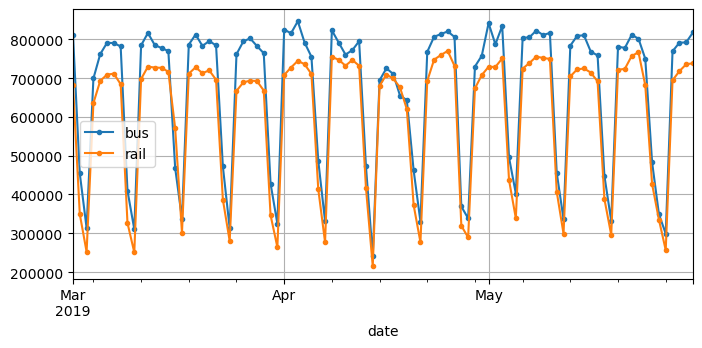

In [12]:
import matplotlib.pyplot as plt

df["2019-03":"2019-05"].plot(grid=True, marker=".", figsize=(8, 3.5))
plt.show()

### 15.3.1 Native Forecasting and Differecing


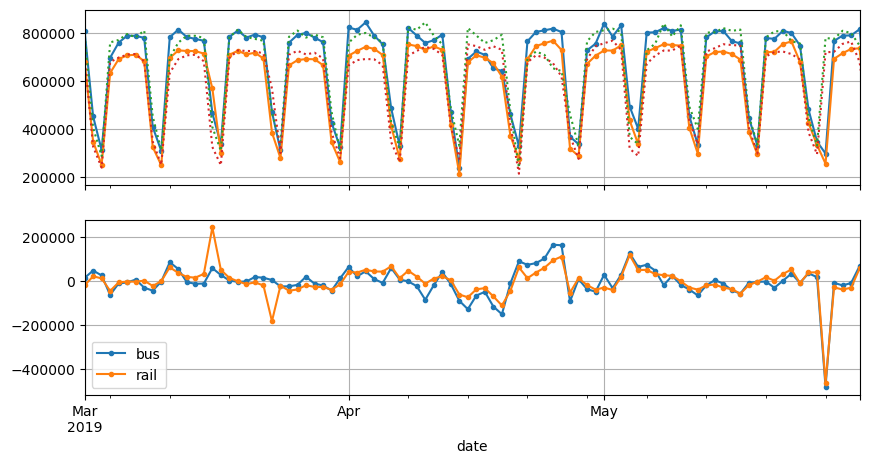

In [ ]:
diff_7 = df[["bus", "rail"]].diff(7)["2019-03":"2019-05"]

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(10, 5))
df.plot(ax=axs[0], legend=False, marker=".")  # original time series
df.shift(7).plot(ax=axs[0], grid=True, legend=False, linestyle=":")  # lagged
diff_7.plot(ax=axs[1], grid=True, marker=".")  # 7-day difference time series
axs[0].set_ylim([170_000, 900_000])  # extra code – beautifies the plot
plt.show()

### Metrics


In [23]:
diff_7.abs().mean() # MAP

bus     43915.608696
rail    42143.271739
dtype: float64

In [29]:
# MAPE
targets = df[["bus", "rail"]]["2019-03":"2019-05"]
(diff_7 / targets).abs().mean()

bus     0.082938
rail    0.089948
dtype: float64

### Yearly Seasonality

**리샘플링(Resampling)** 은 시계열 데이터의 빈도를 변경하는 과정을 의미합니다. 즉, 데이터를 더 짧은 기간으로 세분화하거나(업샘플링), 더 긴 기간으로 묶어서 단순화하는 것(다운샘플링)을 포함합니다.


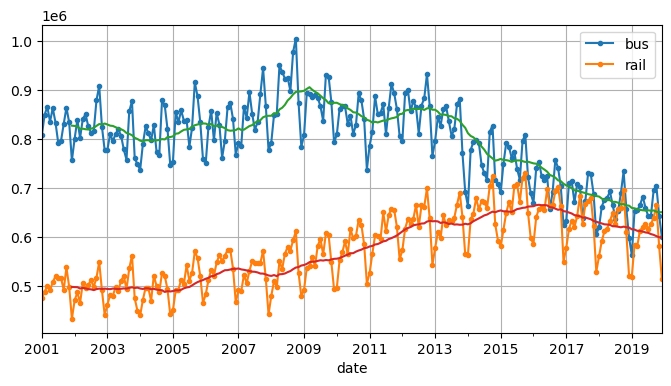

In [ ]:
period = slice("2001", "2019")

# compute the mean for each month
# 월별(ME: Month-End) 데이터로 리샘플링
df_monthly = df[['bus','rail']].resample('ME').mean()  
rolling_average_12_months = df_monthly[period].rolling(window=12).mean()

fig, ax = plt.subplots(figsize=(8, 4))
df_monthly[period].plot(ax=ax, marker=".")
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)

plt.show()

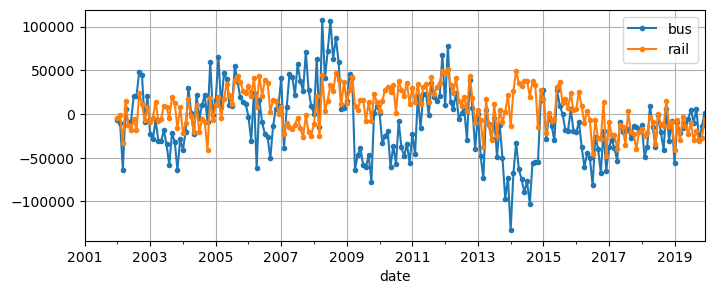

In [41]:
df_monthly.diff(12)[period].plot(grid=True, marker=".", figsize=(8, 3))
plt.show()

### 15.3.1 ARMA


In [42]:
%pip install -q -U statsmodels

Note: you may need to restart the kernel to use updated packages.


In [53]:
from statsmodels.tsa.arima.model import ARIMA

origin, today = "2019-01-01", "2019-05-31"
rail_series = df.loc[origin:today]["rail"].asfreq("D")
model = ARIMA(rail_series,
              order=(1, 0, 0),
              seasonal_order=(0, 1, 1, 7))
model = model.fit()
y_pred = model.forecast()  # returns 427,758.6

In [54]:
y_pred

2019-06-01    427758.626286
Freq: D, dtype: float64

### SARIMA


In [59]:
origin, start_date, end_date = "2019-01-01", "2019-03-01", "2019-05-31"
time_period = pd.date_range(start_date, end_date)
rail_series = df.loc[origin:end_date]["rail"].asfreq("D")
y_preds = []
for today in time_period.shift(-1):
    model = ARIMA(rail_series[origin:today],  # train on data up to "today"
                  order=(1, 0, 0),
                  seasonal_order=(0, 1, 1, 7))
    model = model.fit()  # note that we retrain the model every day!
    y_pred = model.forecast().iloc[0]
    y_preds.append(y_pred)

y_preds = pd.Series(y_preds, index=time_period)
mae = (y_preds - rail_series.loc[time_period]).abs().mean()  # returns 32,040.7

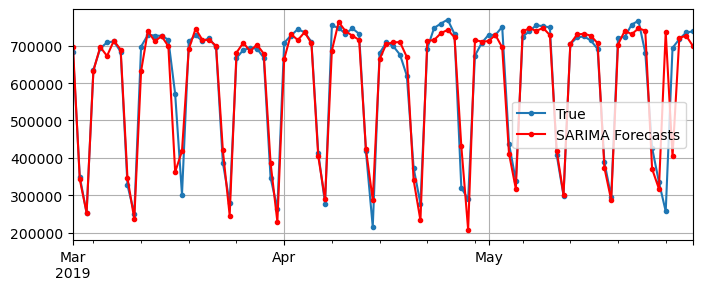

In [61]:
# extra code – displays the SARIMA forecasts
fig, ax = plt.subplots(figsize=(8, 3))
rail_series.loc[time_period].plot(label="True", ax=ax, marker=".", grid=True)
ax.plot(y_preds, color="r", marker=".", label="SARIMA Forecasts")
plt.legend()
plt.show()

### ACF and PACF


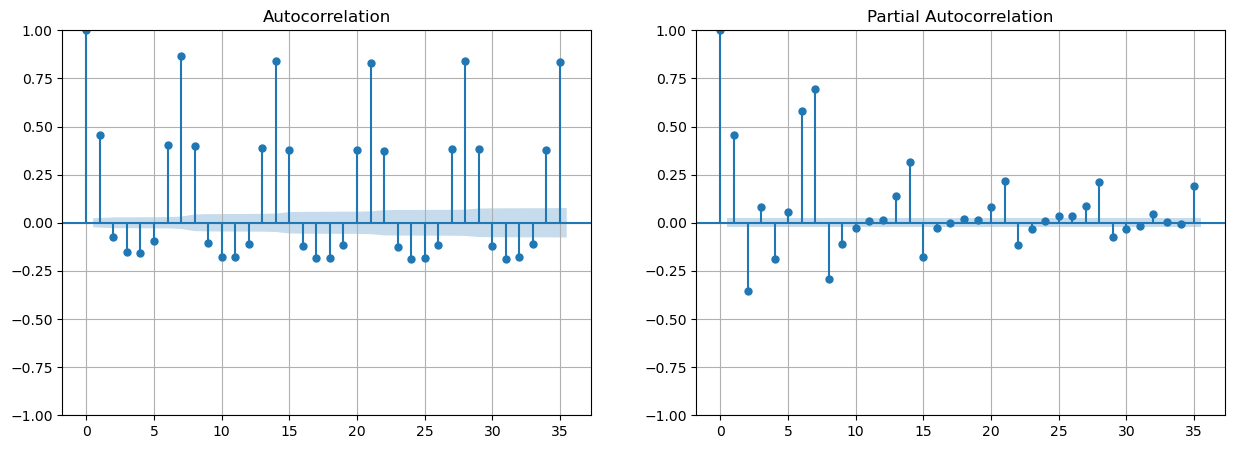

In [69]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
plot_acf(df[period]["rail"], ax=axs[0], lags=35)
axs[0].grid()
plot_pacf(df[period]["rail"], ax=axs[1], lags=35, method="ywm")
axs[1].grid()
plt.show()

### 15.3.2 Prepare Dataset for ML


#### using tf.keras.utils.timeseries_dataset_from_array

- Easy but not inflexible


In [70]:
import tensorflow as tf

my_series = [0, 1, 2, 3, 4, 5]
my_dataset = tf.keras.utils.timeseries_dataset_from_array(
    my_series,
    targets=my_series[3:],  # the targets are 3 steps into the future
    sequence_length=3,
    batch_size=2
)
list(my_dataset)

2025-02-09 15:20:24.227702: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-02-09 15:20:24.227806: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2025-02-09 15:20:24.227815: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2025-02-09 15:20:24.228048: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-02-09 15:20:24.228322: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-02-09 15:20:24.423360: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[0, 1, 2],
         [1, 2, 3]], dtype=int32)>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([3, 4], dtype=int32)>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[2, 3, 4]], dtype=int32)>,
  <tf.Tensor: shape=(1,), dtype=int32, numpy=array([5], dtype=int32)>)]

#### Using window in Dataset

- little complex but flexible


In [79]:
# 플랫 맵 미적용하여 경고 발생
for window_dataset in tf.data.Dataset.range(6).window(4, shift=1):
    for element in window_dataset:
        print(f"{element}", end=" ")
    print()

0 1 2 3 
1 2 3 4 
2 3 4 5 
3 4 5 
4 5 
5 


2025-02-09 15:35:12.153631: W tensorflow/core/framework/dataset.cc:959] Input of Window will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2025-02-09 15:35:12.155971: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-09 15:35:12.159071: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-09 15:35:12.160983: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-09 15:35:12.163110: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-09 15:35:12.165494: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-09 15:35:12.166

In [89]:
dataset = tf.data.Dataset.range(6).window(4, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window_dataset: window_dataset.batch(4))
for window_tensor in dataset:
    print(f"{window_tensor}")

[0 1 2 3]
[1 2 3 4]
[2 3 4 5]


2025-02-10 22:11:08.941431: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [90]:
# 윈도우 함수 및 플랫 맵 적용 

def to_windows(dataset, length):
    dataset = dataset.window(length, shift=1, drop_remainder=True)
    return dataset.flat_map(lambda window_ds: window_ds.batch(length))


dataset = to_windows(tf.data.Dataset.range(6), 4)
dataset = dataset.map(lambda window: (window[:-1], window[-1]))
list(dataset.batch(2))

2025-02-10 22:11:11.534453: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


[(<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
  array([[0, 1, 2],
         [1, 2, 3]])>,
  <tf.Tensor: shape=(2,), dtype=int64, numpy=array([3, 4])>),
 (<tf.Tensor: shape=(1, 3), dtype=int64, numpy=array([[2, 3, 4]])>,
  <tf.Tensor: shape=(1,), dtype=int64, numpy=array([5])>)]

In [91]:
rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06":] / 1e6


# Predict with 56 values to predict tomorrow
seq_length = 56
tf.random.set_seed(42)  # extra code – ensures reproducibility

# Create train dataset 
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
# Create valid dataset
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [92]:
for item in train_ds.take(1):
    print(item)

(<tf.Tensor: shape=(32, 56), dtype=float64, numpy=
array([[0.739158, 0.749136, 0.742502, ..., 0.777158, 0.509314, 0.421479],
       [0.725712, 0.762858, 0.749991, ..., 0.376485, 0.732335, 0.741141],
       [0.770186, 0.764653, 0.78316 , ..., 0.493961, 0.307105, 0.26531 ],
       ...,
       [0.510071, 0.719617, 0.813161, ..., 0.764611, 0.760471, 0.359088],
       [0.464903, 0.351102, 0.76766 , ..., 0.770507, 0.773696, 0.779012],
       [0.733693, 0.77807 , 0.76038 , ..., 0.381042, 0.675484, 0.697126]])>, <tf.Tensor: shape=(32,), dtype=float64, numpy=
array([0.347259, 0.74504 , 0.386058, 0.460892, 0.660176, 0.797545,
       0.755604, 0.755558, 0.393884, 0.770507, 0.712596, 0.741773,
       0.723334, 0.323758, 0.481961, 0.805398, 0.762707, 0.779493,
       0.71522 , 0.272268, 0.692183, 0.730669, 0.320982, 0.796878,
       0.328391, 0.731858, 0.748709, 0.702745, 0.796057, 0.285153,
       0.429256, 0.719511])>)


2025-02-10 22:11:12.936478: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### 15.3.3 Predict with basic linear model


In [95]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[seq_length])
])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae", patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = model.fit(train_ds, validation_data=valid_ds, epochs=500,
                    callbacks=[early_stopping_cb])

# extra code – evaluates the model
valid_loss, valid_mae = model.evaluate(valid_ds)
valid_mae * 1e6

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0249 - mae: 0.1703 - val_loss: 0.0108 - val_mae: 0.1111
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0094 - mae: 0.0964 - val_loss: 0.0077 - val_mae: 0.0888
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0080 - mae: 0.0858 - val_loss: 0.0077 - val_mae: 0.0899
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0066 - mae: 0.0803 - val_loss: 0.0067 - val_mae: 0.0811
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0068 - mae: 0.0806 - val_loss: 0.0064 - val_mae: 0.0788
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0068 - mae: 0.0787 - val_loss: 0.0074 - val_mae: 0.0891
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0077 - mae: 0.0879 - val_loss: 0.0060 - val_mae: 0.0766
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0054 - mae: 0.0720 - val_loss: 0.0062 - val_mae: 0.0789
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.006

37756.551057100296

### 15.3.4 Using the Simple RNN


In [96]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

# extra code – defines a utility function we'll reuse several time

def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=500):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=50, restore_best_weights=True)
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs,
                        callbacks=[early_stopping_cb])
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae * 1e6


fit_and_evaluate(model, train_ds, valid_ds, learning_rate=0.02)

Epoch 1/500


/Users/yunjaecho/Git/practical_ml_dl/env/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 499ms/step - loss: 0.0309 - mae: 0.2168 - val_loss: 0.0123 - val_mae: 0.1141
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 491ms/step - loss: 0.0121 - mae: 0.1179 - val_loss: 0.0123 - val_mae: 0.1127
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 490ms/step - loss: 0.0113 - mae: 0.1131 - val_loss: 0.0120 - val_mae: 0.1126
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 481ms/step - loss: 0.0115 - mae: 0.1158 - val_loss: 0.0118 - val_mae: 0.1122
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 482ms/step - loss: 0.0112 - mae: 0.1142 - val_loss: 0.0117 - val_mae: 0.1117
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 479ms/step - loss: 0.0116 - mae: 0.1182 - val_loss: 0.0115 - val_mae: 0.1114
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 479ms/step - loss: 0.0116 - mae: 0.1166 - val_loss: 0.0114 - val_mae: 0.1110
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 479ms/step - loss: 0.0111 - mae: 0.1158 - val_loss: 0.0113 - val_mae: 0.1107
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 475ms/ste

102743.960916996

In [103]:
# extra code – evaluates the model
valid_loss, valid_mae = model.evaluate(valid_ds)
valid_mae * 1e6

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0099 - mae: 0.0987


102743.960916996

In [110]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
univar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 1]),
    tf.keras.layers.Dense(1)  # no activation function by default
])

# extra code – compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(univar_model, train_ds, valid_ds, learning_rate=0.05, epochs = 10)

Epoch 1/10


/Users/yunjaecho/Git/practical_ml_dl/env/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 531ms/step - loss: 0.0452 - mae: 0.2328 - val_loss: 0.0065 - val_mae: 0.0840
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 496ms/step - loss: 0.0246 - mae: 0.1849 - val_loss: 0.0033 - val_mae: 0.0607
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 507ms/step - loss: 0.0049 - mae: 0.0700 - val_loss: 0.0025 - val_mae: 0.0415
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 537ms/step - loss: 0.0047 - mae: 0.0660 - val_loss: 0.0022 - val_mae: 0.0415
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 512ms/step - loss: 0.0063 - mae: 0.0789 - val_loss: 0.0037 - val_mae: 0.0594
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 503ms/step - loss: 0.0033 - mae: 0.0526 - val_loss: 0.0042 - val_mae: 0.0613
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 481ms/step - loss: 0.0048 - mae: 0.0682 - val_loss: 0.0031 - val_mae: 0.0517
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 484ms/step - loss: 0.0029 - mae: 0.0500 - val_loss: 0.0020 - val_mae: 0.0349
Epoch 9/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 489ms/step - loss

69702.84879207611